In [2]:
# here we remove pH and density from ML model + outlier removing
import pandas as pd
import numpy as np
red_wine=pd.read_csv('../../practice/winequality-red.csv', sep=';')
red_wine.columns= red_wine.columns.str.replace(' ','_')
red_wine

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [3]:
red_wine['quality'].value_counts()

5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64

In [4]:
red_wine.skew()

fixed_acidity           0.982751
volatile_acidity        0.671593
citric_acid             0.318337
residual_sugar          4.540655
chlorides               5.680347
free_sulfur_dioxide     1.250567
total_sulfur_dioxide    1.515531
density                 0.071288
pH                      0.193683
sulphates               2.428672
alcohol                 0.860829
quality                 0.217802
dtype: float64

In [5]:
red_wine.kurt()

fixed_acidity            1.132143
volatile_acidity         1.225542
citric_acid             -0.788998
residual_sugar          28.617595
chlorides               41.715787
free_sulfur_dioxide      2.023562
total_sulfur_dioxide     3.809824
density                  0.934079
pH                       0.806943
sulphates               11.720251
alcohol                  0.200029
quality                  0.296708
dtype: float64

In [6]:
#new column
red_wine['quality_label']=red_wine['quality'].apply(lambda x: 'low' if x <=5 else 'medium' if x<=7 else 'high')
red_wine['quality_label']=pd.Categorical(red_wine['quality_label'], categories=['high','medium','low'])

<AxesSubplot:>

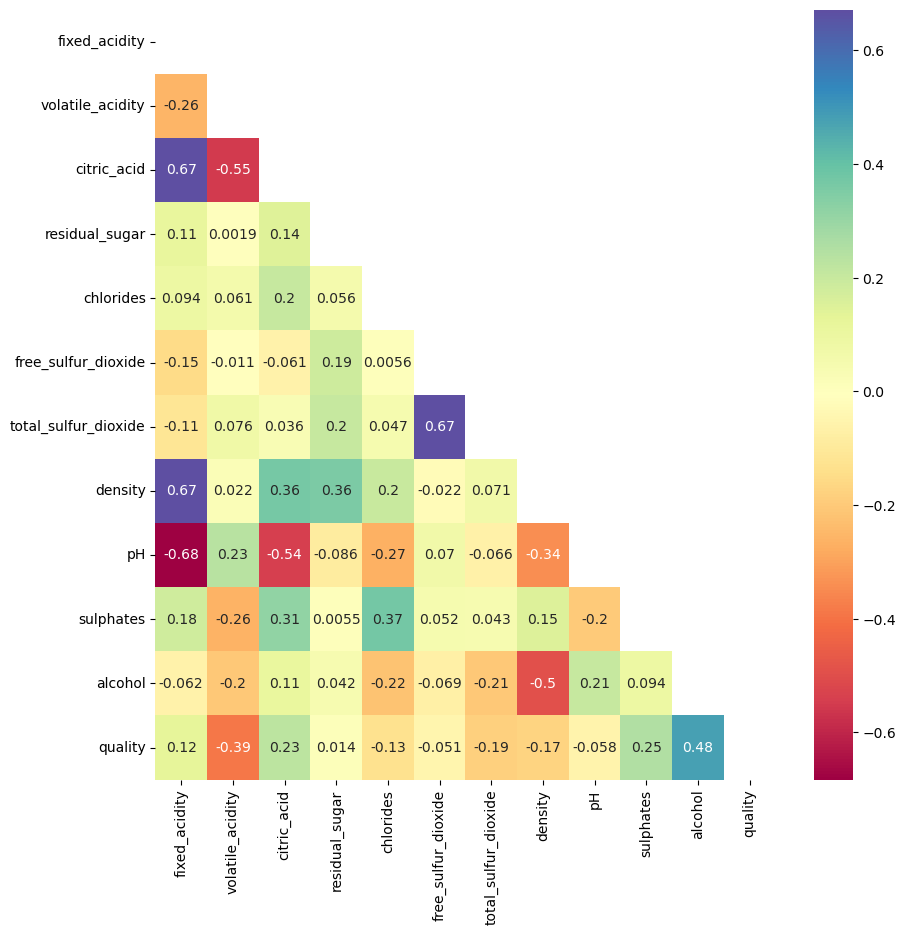

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
fig=plt.figure(figsize=(10,10))

sns.heatmap(red_wine.corr(), mask=np.triu(np.ones_like(red_wine.corr(),dtype=bool)), cmap='Spectral', annot=True)

In [8]:
# sI use z score method to remove outliers
def outliers_remov(df):
    for colu in df.loc[:,'fixed_acidity':'quality']:
        mean_df=df[colu].mean()
        std_df=df[colu].std()
        df_out= df[(df[colu] <= 3*std_df+mean_df) & (df[colu] >= (mean_df-3*std_df))]
        df=df_out       
    return df_out


red_wine=outliers_remov(red_wine)
red_wine= red_wine.set_index(np.arange(len(red_wine)))

In [9]:
#encoding
from sklearn.preprocessing import LabelEncoder
le0=LabelEncoder()
red_wine['quality_label']=le0.fit_transform(red_wine['quality_label'])
le0.inverse_transform(red_wine['quality_label'])

array(['low', 'low', 'low', ..., 'medium', 'low', 'medium'], dtype=object)

In [29]:
# ML for quality of wine Decision tree
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, confusion_matrix, classification_report, accuracy_score
x=red_wine.drop(columns=['quality', 'quality_label'])
y=red_wine['quality_label']
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.3, random_state=0)
scale=MinMaxScaler()
x_train_n=scale.fit_transform(x_train)
x_train_n=pd.DataFrame(x_train_n)
x_test_n=scale.fit_transform(x_test)
x_test_n=pd.DataFrame(x_test_n)
model= DecisionTreeClassifier()
model.fit(x_train_n,y_train)
pred=model.predict(x_test_n)
score=accuracy_score(y_test,pred)
print('Accuracy score : ', score)
print('\nCnofusion Matrix : \n', confusion_matrix(y_test,pred))
print('\nCohen_kappa: ', cohen_kappa_score(y_test,pred))
print('\n classification_report: \n', classification_report(y_test, pred))

Accuracy score :  0.6962616822429907

Cnofusion Matrix : 
 [[  1   0   4]
 [  2 138  54]
 [  9  61 159]]

Cohen_kappa:  0.41323490640653837

 classification_report: 
               precision    recall  f1-score   support

           0       0.08      0.20      0.12         5
           1       0.69      0.71      0.70       194
           2       0.73      0.69      0.71       229

    accuracy                           0.70       428
   macro avg       0.50      0.54      0.51       428
weighted avg       0.71      0.70      0.70       428



In [24]:
# ML for quality of wine Decision tree
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, confusion_matrix, classification_report, accuracy_score
x=red_wine.drop(columns=['quality', 'quality_label', 'pH','density','citric_acid'])
y=red_wine['quality_label']
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.3, random_state=0)
scale=MinMaxScaler()
x_train_n=scale.fit_transform(x_train)
x_train_n=pd.DataFrame(x_train_n)
x_test_n=scale.fit_transform(x_test)
x_test_n=pd.DataFrame(x_test_n)
model= DecisionTreeClassifier()
model.fit(x_train_n,y_train)
pred=model.predict(x_test_n)
score=accuracy_score(y_test,pred)
print('Accuracy score : ', score)
print('\nCnofusion Matrix : \n', confusion_matrix(y_test,pred))
print('\nCohen_kappa: ', cohen_kappa_score(y_test,pred))
print('\n classification_report: \n', classification_report(y_test, pred))

Accuracy score :  0.6845794392523364

Cnofusion Matrix : 
 [[  1   0   4]
 [  0 136  58]
 [ 10  63 156]]

Cohen_kappa:  0.38922421538884366

 classification_report: 
               precision    recall  f1-score   support

           0       0.09      0.20      0.13         5
           1       0.68      0.70      0.69       194
           2       0.72      0.68      0.70       229

    accuracy                           0.68       428
   macro avg       0.50      0.53      0.51       428
weighted avg       0.69      0.68      0.69       428



In [12]:
# ML for quality of wine RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, confusion_matrix, classification_report, accuracy_score
x=red_wine.drop(columns=['quality', 'quality_label', 'pH','density','citric_acid'])
y=red_wine['quality_label']
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.3, random_state=0)
scale=MinMaxScaler()
x_train_n=scale.fit_transform(x_train)
x_train_n=pd.DataFrame(x_train_n)
x_test_n=scale.fit_transform(x_test)
x_test_n=pd.DataFrame(x_test_n)
model= RandomForestClassifier()
model.fit(x_train_n,y_train)
pred=model.predict(x_test_n)
score=accuracy_score(y_test,pred)
print('Accuracy score : ', score)
print('\nCnofusion Matrix : \n', confusion_matrix(y_test,pred))
print('\nCohen_kappa: ', cohen_kappa_score(y_test,pred))
print('\n classification_report: \n', classification_report(y_test, pred))

Accuracy score :  0.7757009345794392

Cnofusion Matrix : 
 [[  0   0   5]
 [  0 151  43]
 [  1  47 181]]

Cohen_kappa:  0.5549682646275156

 classification_report: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.76      0.78      0.77       194
           2       0.79      0.79      0.79       229

    accuracy                           0.78       428
   macro avg       0.52      0.52      0.52       428
weighted avg       0.77      0.78      0.77       428



In [13]:
# ML for quality of wine LinearDiscriminantAnalysis
from sklearn.preprocessing import MinMaxScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, confusion_matrix, classification_report, accuracy_score
x=red_wine.drop(columns=['quality', 'quality_label', 'pH','density','citric_acid'])
y=red_wine['quality_label']
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.3, random_state=0)
scale=MinMaxScaler()
x_train_n=scale.fit_transform(x_train)
x_train_n=pd.DataFrame(x_train_n)
x_test_n=scale.fit_transform(x_test)
x_test_n=pd.DataFrame(x_test_n)
model= LinearDiscriminantAnalysis()
model.fit(x_train_n,y_train)
pred=model.predict(x_test_n)
score=accuracy_score(y_test,pred)
print('Accuracy score : ', score)
print('\nCnofusion Matrix : \n', confusion_matrix(y_test,pred))
print('\nCohen_kappa: ', cohen_kappa_score(y_test,pred))
print('\n classification_report: \n', classification_report(y_test, pred))

Accuracy score :  0.7546728971962616

Cnofusion Matrix : 
 [[  0   0   5]
 [  0 140  54]
 [  3  43 183]]

Cohen_kappa:  0.5128402475907599

 classification_report: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.77      0.72      0.74       194
           2       0.76      0.80      0.78       229

    accuracy                           0.75       428
   macro avg       0.51      0.51      0.51       428
weighted avg       0.75      0.75      0.75       428



In [14]:
# ML for quality of wine GaussianNB
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, confusion_matrix, classification_report, accuracy_score
x=red_wine.drop(columns=['quality', 'quality_label', 'pH','density','citric_acid'])
y=red_wine['quality_label']
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.3, random_state=0)
scale=MinMaxScaler()
x_train_n=scale.fit_transform(x_train)
x_train_n=pd.DataFrame(x_train_n)
x_test_n=scale.fit_transform(x_test)
x_test_n=pd.DataFrame(x_test_n)
model= GaussianNB()
model.fit(x_train_n,y_train)
pred=model.predict(x_test_n)
score=accuracy_score(y_test,pred)
print('Accuracy score : ', score)
print('\nCnofusion Matrix : \n', confusion_matrix(y_test,pred))
print('\nCohen_kappa: ', cohen_kappa_score(y_test,pred))
print('\n classification_report: \n', classification_report(y_test, pred))
importance=

Accuracy score :  0.7336448598130841

Cnofusion Matrix : 
 [[  1   0   4]
 [  0 144  50]
 [  6  54 169]]

Cohen_kappa:  0.47910750507099387

 classification_report: 
               precision    recall  f1-score   support

           0       0.14      0.20      0.17         5
           1       0.73      0.74      0.73       194
           2       0.76      0.74      0.75       229

    accuracy                           0.73       428
   macro avg       0.54      0.56      0.55       428
weighted avg       0.74      0.73      0.74       428



In [15]:
# ML for quality of wine KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, confusion_matrix, classification_report, accuracy_score
x=red_wine.drop(columns=['quality', 'quality_label', 'pH','density','citric_acid'])
y=red_wine['quality_label']
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.3, random_state=0)
scale=MinMaxScaler()
x_train_n=scale.fit_transform(x_train)
x_train_n=pd.DataFrame(x_train_n)
x_test_n=scale.fit_transform(x_test)
x_test_n=pd.DataFrame(x_test_n)
model= KNeighborsClassifier()
model.fit(x_train_n,y_train)
pred=model.predict(x_test_n)
score=accuracy_score(y_test,pred)
print('Accuracy score : ', score)
print('\nCnofusion Matrix : \n', confusion_matrix(y_test,pred))
print('\nCohen_kappa: ', cohen_kappa_score(y_test,pred))
print('\n classification_report: \n', classification_report(y_test, pred))

Accuracy score :  0.7266355140186916

Cnofusion Matrix : 
 [[  0   0   5]
 [  0 132  62]
 [  0  50 179]]

Cohen_kappa:  0.4529724061086714

 classification_report: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.73      0.68      0.70       194
           2       0.73      0.78      0.75       229

    accuracy                           0.73       428
   macro avg       0.48      0.49      0.49       428
weighted avg       0.72      0.73      0.72       428



/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: U

In [16]:
# ML for quality of wine SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, confusion_matrix, classification_report, accuracy_score
x=red_wine.drop(columns=['quality', 'quality_label', 'pH','density','citric_acid'])
y=red_wine['quality_label']
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.3, random_state=0)
scale=MinMaxScaler()
x_train_n=scale.fit_transform(x_train)
x_train_n=pd.DataFrame(x_train_n)
x_test_n=scale.fit_transform(x_test)
x_test_n=pd.DataFrame(x_test_n)
model= SVC()
model.fit(x_train_n,y_train)
pred=model.predict(x_test_n)
score=accuracy_score(y_test,pred)
print('Accuracy score : ', score)
print('\nCnofusion Matrix : \n', confusion_matrix(y_test,pred))
print('\nCohen_kappa: ', cohen_kappa_score(y_test,pred))
print('\n classification_report: \n', classification_report(y_test, pred))

Accuracy score :  0.7663551401869159

Cnofusion Matrix : 
 [[  0   0   5]
 [  0 152  42]
 [  0  53 176]]

Cohen_kappa:  0.5365306940127995

 classification_report: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.74      0.78      0.76       194
           2       0.79      0.77      0.78       229

    accuracy                           0.77       428
   macro avg       0.51      0.52      0.51       428
weighted avg       0.76      0.77      0.76       428



/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [17]:
# ML for quality of wine AdaBoostClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, confusion_matrix, classification_report, accuracy_score
x=red_wine.drop(columns=['quality', 'quality_label', 'pH','density','citric_acid'])
y=red_wine['quality_label']
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.3, random_state=0)
scale=MinMaxScaler()
x_train_n=scale.fit_transform(x_train)
x_train_n=pd.DataFrame(x_train_n)
x_test_n=scale.fit_transform(x_test)
x_test_n=pd.DataFrame(x_test_n)
model= AdaBoostClassifier()
model.fit(x_train_n,y_train)
pred=model.predict(x_test_n)
score=accuracy_score(y_test,pred)
print('Accuracy score : ', score)
print('\nCnofusion Matrix : \n', confusion_matrix(y_test,pred))
print('\nCohen_kappa: ', cohen_kappa_score(y_test,pred))
print('\n classification_report: \n', classification_report(y_test, pred))

Accuracy score :  0.7313084112149533

Cnofusion Matrix : 
 [[  2   0   3]
 [  0 164  30]
 [  5  77 147]]

Cohen_kappa:  0.48284738639348557

 classification_report: 
               precision    recall  f1-score   support

           0       0.29      0.40      0.33         5
           1       0.68      0.85      0.75       194
           2       0.82      0.64      0.72       229

    accuracy                           0.73       428
   macro avg       0.59      0.63      0.60       428
weighted avg       0.75      0.73      0.73       428

